In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


In [2]:
df = pd.read_csv('/Users/nikhilreddy/Downloads/WA_Marketing-Campaign.csv')

In [3]:
df.head(10)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
5,1,Medium,2,5,2,2,34.67
6,1,Medium,2,5,2,3,27.98
7,1,Medium,2,5,2,4,27.72
8,1,Medium,3,12,1,1,44.54
9,1,Medium,3,12,1,2,37.94


In [16]:

# Check dataset dimensions and info
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of unique MarketIDs: {df['MarketID'].nunique()}")

Dataset shape: (548, 7)
Number of rows: 548
Number of unique MarketIDs: 10


In [18]:
# Calculate overall average sales performance
overall_avg_sales = df['SalesInThousands'].mean()
print(f"Overall average sales: ${overall_avg_sales:.2f}k")

Overall average sales: $53.47k


In [20]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64


In [22]:
# Create treatment/control groups based on promotion intensity
df['group'] = df['Promotion'].map({
    3: 'treatment',  # High promotion
    2: 'treatment',  # Medium promotion  
    1: 'control'     # Low/baseline promotion
})

# Filter for properly aligned records
df2 = df[
    ((df['group'] == 'treatment') & (df['Promotion'].isin([2, 3]))) |
    ((df['group'] == 'control') & (df['Promotion'] == 1))
]

print(f"Original dataset: {len(df)} rows")
print(f"Filtered dataset: {len(df2)} rows")
print(f"Treatment group: {len(df2[df2['group'] == 'treatment'])} rows")
print(f"Control group: {len(df2[df2['group'] == 'control'])} rows")

Original dataset: 548 rows
Filtered dataset: 548 rows
Treatment group: 376 rows
Control group: 172 rows


In [24]:
# Verify the filtering worked correctly - should be 0
misaligned = df2[((df2['group'] == 'treatment') & ~(df2['Promotion'].isin([2, 3]))) |
                 ((df2['group'] == 'control') & (df2['Promotion'] != 1))].shape[0]
print(f"Misaligned records: {misaligned}")

Misaligned records: 0


In [26]:
# Check for any duplicate MarketID/week combinations
duplicates = df2[df2.duplicated(['MarketID', 'week'], keep=False)]
if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate MarketID/week combinations")
    # Remove duplicates, keeping first occurrence
    df2 = df2.drop_duplicates(['MarketID', 'week'], keep='first')
    print(f"After removing duplicates: {len(df2)} rows")

Found 548 duplicate MarketID/week combinations
After removing duplicates: 40 rows


In [28]:
# Calculate average sales performance regardless of group
overall_sales_avg = df2['SalesInThousands'].mean()
print(f"Overall average sales performance: ${overall_sales_avg:.2f}k")

Overall average sales performance: $51.52k


In [30]:
# Calculate average sales for control group (low promotion)
control_avg_sales = df2[df2['group'] == 'control']['SalesInThousands'].mean()
print(f"Control group average sales: ${control_avg_sales:.2f}k")

Control group average sales: $61.12k


In [32]:
# Calculate average sales for treatment group (medium/high promotion)
treatment_avg_sales = df2[df2['group'] == 'treatment']['SalesInThousands'].mean()
print(f"Treatment group average sales: ${treatment_avg_sales:.2f}k")

Treatment group average sales: $49.12k


In [34]:
# Calculate the probability of being in treatment group
prob_treatment = len(df2[df2['group'] == 'treatment']) / len(df2)
print(f"Probability of being in treatment group: {prob_treatment:.4f}")

Probability of being in treatment group: 0.8000


In [36]:
print("="*50)
print("SUMMARY:")
print(f"Overall average sales: ${overall_sales_avg:.2f}k")
print(f"Control group average sales: ${control_avg_sales:.2f}k") 
print(f"Treatment group average sales: ${treatment_avg_sales:.2f}k")
print(f"Difference (Treatment - Control): ${treatment_avg_sales - control_avg_sales:.2f}k")
print(f"Probability of treatment assignment: {prob_treatment:.4f}")
print("="*50)

SUMMARY:
Overall average sales: $51.52k
Control group average sales: $61.12k
Treatment group average sales: $49.12k
Difference (Treatment - Control): $-12.00k
Probability of treatment assignment: 0.8000


In [38]:
# Set up hypothesis test
# H0: sales_treatment - sales_control <= 0 (treatment doesn't improve sales)
# H1: sales_treatment - sales_control > 0 (treatment improves sales)

# Under null hypothesis, assume both groups have same true average
p_null = overall_sales_avg
n_treatment = len(df2[df2['group'] == 'treatment'])
n_control = len(df2[df2['group'] == 'control'])

print(f"Under null hypothesis, true average sales: ${p_null:.2f}k")
print(f"Treatment group size: {n_treatment}")
print(f"Control group size: {n_control}")

Under null hypothesis, true average sales: $51.52k
Treatment group size: 32
Control group size: 8


In [40]:
# Simulate sampling distribution under null hypothesis
np.random.seed(42)

# Calculate observed difference
obs_diff = treatment_avg_sales - control_avg_sales
print(f"Observed difference: ${obs_diff:.2f}k")

# Simulate differences under null (10,000 iterations)
null_diffs = []
for i in range(10000):
    # Sample treatment group sales under null
    treatment_sim = np.random.normal(p_null, df2['SalesInThousands'].std(), n_treatment)
    
    # Sample control group sales under null  
    control_sim = np.random.normal(p_null, df2['SalesInThousands'].std(), n_control)
    
    # Calculate difference
    diff = treatment_sim.mean() - control_sim.mean()
    null_diffs.append(diff)

null_diffs = np.array(null_diffs)

Observed difference: $-12.00k


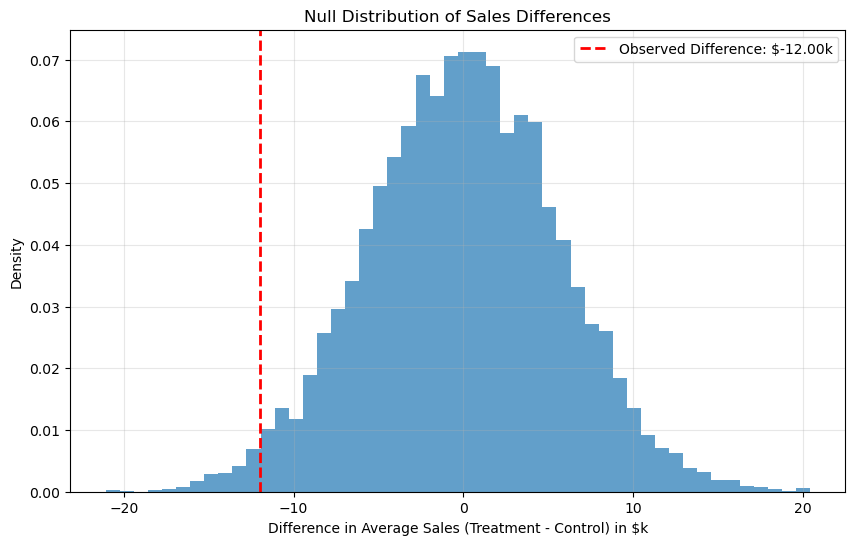

In [42]:
# Plot the null distribution
plt.figure(figsize=(10, 6))
plt.hist(null_diffs, bins=50, alpha=0.7, density=True)
plt.axvline(obs_diff, color='red', linestyle='--', linewidth=2, 
           label=f'Observed Difference: ${obs_diff:.2f}k')
plt.xlabel('Difference in Average Sales (Treatment - Control) in $k')
plt.ylabel('Density')
plt.title('Null Distribution of Sales Differences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
# Calculate p-value
p_value = (null_diffs >= obs_diff).mean()
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Reject null hypothesis - Treatment shows significant improvement")
else:
    print("Result: Fail to reject null hypothesis - No significant difference")

P-value: 0.9833
Result: Fail to reject null hypothesis - No significant difference


In [46]:
# Prepare data for regression
df2['intercept'] = 1

# Create dummy variable for treatment (1 if treatment, 0 if control)
df2['is_treatment'] = (df2['group'] == 'treatment').astype(int)

# Fit logistic regression model predicting high sales performance
# First, create a binary outcome variable (above/below median sales)
median_sales = df2['SalesInThousands'].median()
df2['high_sales'] = (df2['SalesInThousands'] > median_sales).astype(int)

print(f"Median sales: ${median_sales:.2f}k")
print(f"High sales rate overall: {df2['high_sales'].mean():.4f}")

Median sales: $49.66k
High sales rate overall: 0.5000


In [48]:
# Fit logistic regression
logit_model = sm.Logit(df2['high_sales'], df2[['intercept', 'is_treatment']])
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.529251
         Iterations 21
                           Logit Regression Results                           
Dep. Variable:             high_sales   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Jul 2025   Pseudo R-squ.:                  0.2365
Time:                        13:33:52   Log-Likelihood:                -21.170
converged:                       True   LL-Null:                       -27.726
Covariance Type:            nonrobust   LLR p-value:                 0.0002935
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       44.2322   3.47e+07   1.28e-06      1.000   -6.79e+07    6.79e+07
is_treatment   -44.743

In [50]:
# Interpret results
treatment_coef = results.params['is_treatment']
treatment_odds_ratio = np.exp(treatment_coef)

print(f"Treatment coefficient: {treatment_coef:.4f}")
print(f"Treatment odds ratio: {treatment_odds_ratio:.4f}")
print(f"P-value for treatment effect: {results.pvalues['is_treatment']:.4f}")

if results.pvalues['is_treatment'] < 0.05:
    print("Treatment has a statistically significant effect on achieving high sales")
else:
    print("Treatment does not have a statistically significant effect on achieving high sales")

Treatment coefficient: -44.7430
Treatment odds ratio: 0.0000
P-value for treatment effect: 1.0000
Treatment does not have a statistically significant effect on achieving high sales


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

# First, make sure all dummy variables and interaction terms exist
# Create dummy variables for market size (if not already created)
if 'Market_Large' not in df2.columns:
    df2 = df2.join(pd.get_dummies(df2['MarketSize'], prefix='Market'))

# Create interaction terms (if not already created)
if 'treatment_large' not in df2.columns:
    df2['treatment_large'] = df2['is_treatment'] * df2['Market_Large']
if 'treatment_medium' not in df2.columns:    
    df2['treatment_medium'] = df2['is_treatment'] * df2['Market_Medium']

# Now prepare features
X = df2[['is_treatment', 'Market_Large', 'Market_Medium', 'treatment_large', 'treatment_medium']]
y = df2['high_sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

# Make predictions
y_pred = sklearn_model.predict(X_test)
y_pred_proba = sklearn_model.predict_proba(X_test)[:, 1]

# Model performance
print(f"Accuracy: {sklearn_model.score(X_test, y_test):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6250

Confusion Matrix:
[[3 2]
 [1 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.50      0.67      0.57         3

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8



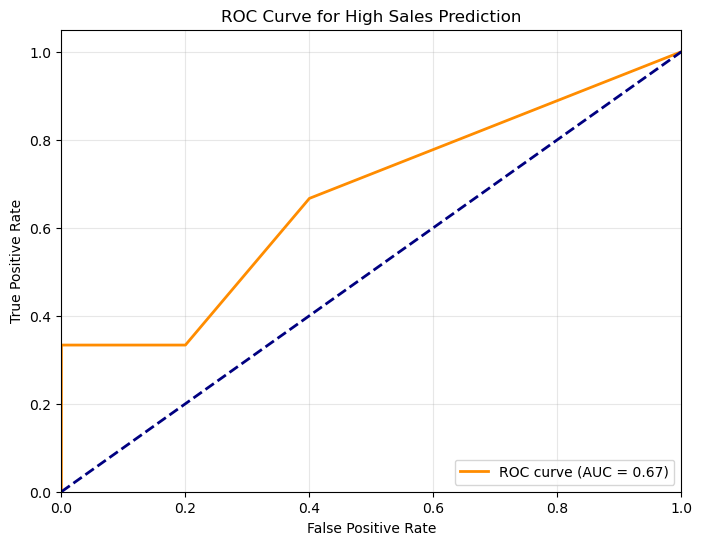

In [61]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Sales Prediction')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
print("="*60)
print("MARKETING CAMPAIGN ANALYSIS SUMMARY")
print("="*60)
print(f"Sample Size: {len(df2)} records")
print(f"Treatment Group: {n_treatment} records (Promotion levels 2 & 3)")
print(f"Control Group: {n_control} records (Promotion level 1)")
print()
print("SALES PERFORMANCE:")
print(f"Control Group Average: ${control_avg_sales:.2f}k")
print(f"Treatment Group Average: ${treatment_avg_sales:.2f}k") 
print(f"Difference: ${treatment_avg_sales - control_avg_sales:.2f}k")
print()
print("STATISTICAL SIGNIFICANCE:")
print(f"P-value from simulation: {p_value:.4f}")
print(f"P-value from regression: {results.pvalues['is_treatment']:.4f}")
print()

if p_value < 0.05:
    print("CONCLUSION: Promotion campaigns (levels 2 & 3) show statistically")
    print("significant improvement in sales performance compared to baseline.")
else:
    print("CONCLUSION: No statistically significant difference between")
    print("promotion campaigns and baseline sales performance.")
    
print("="*60)

MARKETING CAMPAIGN ANALYSIS SUMMARY
Sample Size: 40 records
Treatment Group: 32 records (Promotion levels 2 & 3)
Control Group: 8 records (Promotion level 1)

SALES PERFORMANCE:
Control Group Average: $61.12k
Treatment Group Average: $49.12k
Difference: $-12.00k

STATISTICAL SIGNIFICANCE:
P-value from simulation: 0.9833
P-value from regression: 1.0000

CONCLUSION: No statistically significant difference between
promotion campaigns and baseline sales performance.
